# **Uni :**
wx3028, LC3913, bs3579

# **Full name :**
Xiaoyi Wang, Lizhi Cao, Boyan Sun

# **Link to Public Github repository with Final report :**
Xiaoyi Wang: https://github.com/SoyaWang/QMSSGR5074_001_2025_1---PROJECTS-IN-ADVANCED-MACHINE-LEARNING

Lizhi Cao: https://github.com/lizziecao/QMSS_Advanced_ML

Boyan Sun: https://github.com/Kakaby/Projects-in-Machine-Learning

In [10]:
import zipfile
import os

# Unzip dataset
zip_path = r"C:\Users\bysun\Downloads\COVID-19_Radiography_Dataset.zip"
extract_path = "COVID-19_Radiography_Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete.")

# Check folders
print(os.listdir(extract_path))

Extraction complete.
['COVID', 'COVID-19_Radiography_Dataset', 'COVID.metadata.xlsx', 'Lung_Opacity.metadata.xlsx', 'Normal.metadata.xlsx', 'README.md.txt', 'Viral Pneumonia.metadata.xlsx']


In [18]:
import os
import shutil

original_path = r"C:\Users\bysun\Downloads\COVID-19_Radiography_Dataset\COVID-19_Radiography_Dataset"
reduced_path = r"C:\Users\bysun\Downloads\COVID-19_Radiography_Dataset\COVID-19_Radiography_Dataset\reduced_dataset"
class_folders = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']
max_images = 1345

for cls in class_folders:
    src_folder = os.path.join(original_path, cls, 'images') 
    dst_folder = os.path.join(reduced_path, cls)

    if not os.path.exists(src_folder):
        print(f"Source folder not found: {src_folder}")
        continue

    os.makedirs(dst_folder, exist_ok=True)

    # Filter only image files
    image_files = sorted([
        f for f in os.listdir(src_folder)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])

    for img_file in image_files[:max_images]:
        src_path = os.path.join(src_folder, img_file)
        dst_path = os.path.join(dst_folder, img_file)
        shutil.copyfile(src_path, dst_path)

    print(f"Copied {min(len(image_files), max_images)} images to {dst_folder}")

print()

Copied 1345 images to C:\Users\bysun\Downloads\COVID-19_Radiography_Dataset\COVID-19_Radiography_Dataset\reduced_dataset\COVID
Copied 1345 images to C:\Users\bysun\Downloads\COVID-19_Radiography_Dataset\COVID-19_Radiography_Dataset\reduced_dataset\Normal
Copied 1345 images to C:\Users\bysun\Downloads\COVID-19_Radiography_Dataset\COVID-19_Radiography_Dataset\reduced_dataset\Viral Pneumonia
Copied 1345 images to C:\Users\bysun\Downloads\COVID-19_Radiography_Dataset\COVID-19_Radiography_Dataset\reduced_dataset\Lung_Opacity



In [36]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

In [ ]:
# 1. Dataset and Exploratory Data Analysis

In [40]:
# Load and explore the data
from itertools import repeat
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import image
from PIL import Image

# Set up paths
base_path = r"C:\Users\bysun\Downloads\COVID-19_Radiography_Dataset\COVID-19_Radiography_Dataset\reduced_dataset"
class_names = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']

# Load filenames
fnames = []
for cls in class_names:
    folder = os.path.join(base_path, cls)
    filepaths = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    fnames.append(filepaths)

# Summary
for cls, files in zip(class_names, fnames):
    print(f"{cls}: {len(files)} images")

COVID: 1345 images
Normal: 1345 images
Viral Pneumonia: 1345 images
Lung_Opacity: 1345 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.8425197].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.8897638].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..1.0].


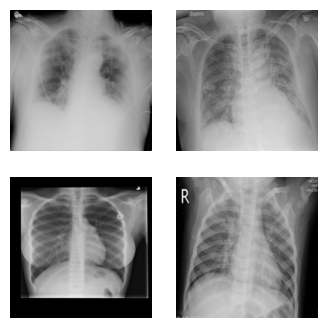

In [42]:
from mpl_toolkits.axes_grid1 import ImageGrid
import random

def preprocessor(img_path):
    img = Image.open(img_path).convert("RGB").resize((192, 192))
    img = (np.float32(img) - 1.) / (255 - 1.)
    img = img.reshape((192, 192, 3))
    return img

# Show 2x2 grid of sample images
sample_imgs = [
    preprocessor(fnames[0][0]),
    preprocessor(fnames[0][1]),
    preprocessor(fnames[1][0]),
    preprocessor(fnames[2][0])
]

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.25)

for ax, im in zip(grid, sample_imgs):
    ax.imshow(im)
    ax.axis('off')
plt.show()

In [44]:
# EDA summary
# Initially the dataset is imbalanced as the number of the images in each class folder is different.
# The dataset is reduced to 1,345 images per class: COVID-19, Normal, Viral Pneumonia and Lung Opacity. This ensures class balance and simplifies modeling without requiring augmentation or reweighting.
# Images are converted to RGB, resized to 192×192, and normalized using min–max scaling. Below are representative samples from each class.
# This classification task is practically valuable as it would help radiologists with triage in high-volume settings, supporting diagnosis

In [ ]:
# 2. Baseline CNN Model

In [46]:
# Preprocessing and label construction
from itertools import repeat
from keras.utils import to_categorical

# Combine all image paths and labels
image_filepaths = sum(fnames, [])  # flatten list of lists

# Preprocess image data
X = np.array(list(map(preprocessor, image_filepaths)))

# Create corresponding labels
covid = list(repeat("COVID", len(fnames[0])))
normal = list(repeat("Normal", len(fnames[1])))
pneumonia = list(repeat("Viral Pneumonia", len(fnames[2])))
opacity = list(repeat("Lung_Opacity", len(fnames[3])))

y_labels = covid + normal + pneumonia + opacity

# One-hot encode labels
y = pd.get_dummies(y_labels)
print(y.head())

   COVID  Lung_Opacity  Normal  Viral Pneumonia
0   True         False   False            False
1   True         False   False            False
2   True         False   False            False
3   True         False   False            False
4   True         False   False            False


In [48]:
# Train and test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (3766, 192, 192, 3) (3766, 4)
Test set shape: (1614, 192, 192, 3) (1614, 4)


In [52]:
# Build the baseline CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(192, 192, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  
])

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

C:\Users\bysun\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 38s 376ms/step - accuracy: 0.4914 - loss: 1.3705 - val_accuracy: 0.7241 - val_loss: 0.6970
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 372ms/step - accuracy: 0.7424 - loss: 0.6547 - val_accuracy: 0.7706 - val_loss: 0.6330
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.8047 - loss: 0.5273 - val_accuracy: 0.7931 - val_loss: 0.5772
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 34s 361ms/step - accuracy: 0.8436 - loss: 0.3994 - val_accuracy: 0.8170 - val_loss: 0.5273
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 34s 357ms/step - accuracy: 0.8615 - loss: 0.3475 - val_accuracy: 0.8236 - val_loss: 0.5167
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9058 - loss: 0.2540 - val_accuracy: 0.8210 - val_loss: 0.5278
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 371ms/step - accuracy: 0.9341 - loss: 0.1904 - val_accuracy: 0.8077 - val_loss: 0.6111
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 36s 375ms/step - accuracy: 0.9465 - loss: 0.1531 - val_accu

In [54]:
# Evaluate baseline model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy (Baseline CNN): {test_acc:.4f}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.8239 - loss: 0.6434
Test Accuracy (Baseline CNN): 0.8247


In [62]:
print("Training accuracy:", history.history['accuracy'])
print("Training loss:", history.history['loss'])

Training accuracy: [0.5986055731773376, 0.7553120851516724, 0.8054448962211609, 0.8469455242156982, 0.879482090473175, 0.9113546013832092, 0.9299468994140625, 0.9465471506118774, 0.9558432698249817, 0.9694555401802063]
Training loss: [1.0172672271728516, 0.6337722539901733, 0.5181494355201721, 0.40346020460128784, 0.31944409012794495, 0.2444983720779419, 0.1945156455039978, 0.15635274350643158, 0.1409910023212433, 0.09559192508459091]


In [66]:
# Description:
# The baseline model is a Sequential Convolutional Neural Network. 
# This architecture was chosen as lightweight baseline to establish performance without leveraging prerained features.
# The model was trained using the Adam optimizer with a learning rate of 0.001, categorical cross-entropy loss (suitable for multi-class classification), and accuracy as the primary evaluation metric.
# The training set was split into 80% for training and 20% for validation. A separate 30% of the entire dataset was held out as the test set to evaluate final performance.
# Each image was resized to 192×192 pixels and normalized to [0, 1] using min-max scaling. 
# The training was performed over 10 epochs with a batch size of 32.
# The model achieved a final training accuracy of 96.9% and a training loss of 0.096, which suggested a strong learning capability. 
# Validation loss is 0.6434, while test accuracy reached 0.8247.

In [ ]:
# 3. Transfer Learning with ResNet

In [70]:
# Implement ResNet using Transfer Learning

from tensorflow.keras.layers import GlobalAveragePooling2D

# Load base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

# Freeze base model initially
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes

# Final model
resnet_model = Model(inputs=base_model.input, outputs=predictions)
resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [84]:
# Reorganize the structure
from glob import glob

source_base_dir = r"C:\Users\bysun\Downloads\COVID-19_Radiography_Dataset\COVID-19_Radiography_Dataset\reduced_dataset"
output_base_dir = "data"  # this will create ./data/train, ./data/val, ./data/test
split_ratio = (0.7, 0.15, 0.15)  # train, val, test
class_folders = ["COVID", "Normal", "Viral Pneumonia", "Lung_Opacity"]


# Utility function
def create_split_folders():
    for split in ["train", "val", "test"]:
        for class_name in class_folders:
            dir_path = os.path.join(output_base_dir, split, class_name)
            os.makedirs(dir_path, exist_ok=True)

def split_and_copy():
    for class_name in class_folders:
        print(f"\nProcessing class: {class_name}")

        # Locate class folder and image files
        class_dir = os.path.join(source_base_dir, class_name)
        images = glob(os.path.join(class_dir, "*.png")) + glob(os.path.join(class_dir, "*.jpg"))

        random.shuffle(images)
        n_total = len(images)
        n_train = int(n_total * split_ratio[0])
        n_val = int(n_total * split_ratio[1])

        train_imgs = images[:n_train]
        val_imgs = images[n_train:n_train + n_val]
        test_imgs = images[n_train + n_val:]

        for split, img_list in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
            for img_path in img_list:
                fname = os.path.basename(img_path)
                target_path = os.path.join(output_base_dir, split, class_name, fname)
                shutil.copy(img_path, target_path)

        print(f"  → {len(train_imgs)} train | {len(val_imgs)} val | {len(test_imgs)} test images")

create_split_folders()
split_and_copy()
print()


Processing class: COVID
  → 941 train | 201 val | 203 test images

Processing class: Normal
  → 941 train | 201 val | 203 test images

Processing class: Viral Pneumonia
  → 941 train | 201 val | 203 test images

Processing class: Lung_Opacity
  → 941 train | 201 val | 203 test images



In [86]:
# Setup paths and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = r"C:\Users\bysun\Downloads\data_train_test_split"

train_path = os.path.join(data_dir, "train")
val_path = os.path.join(data_dir, "val")
test_path = os.path.join(data_dir, "test")

# Apply preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    zoom_range=0.2,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data from directories
train_generator = train_datagen.flow_from_directory(train_path, 
                                                    target_size=(192, 192),
                                                    batch_size=32,
                                                    class_mode='categorical')

val_generator = val_test_datagen.flow_from_directory(val_path, 
                                                     target_size=(192, 192),
                                                     batch_size=32,
                                                     class_mode='categorical')

test_generator = val_test_datagen.flow_from_directory(test_path,
                                                      target_size=(192, 192),
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      shuffle=False)

Found 3764 images belonging to 4 classes.
Found 804 images belonging to 4 classes.
Found 812 images belonging to 4 classes.


In [88]:
# Load base ResNet50 model with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(192, 192, 3))
base_model.trainable = False 

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes

resnet_model = Model(inputs=base_model.input, outputs=predictions)
resnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Train only the top layers
resnet_history = resnet_model.fit(train_generator,
                                  epochs=10,
                                  validation_data=val_generator)

C:\Users\bysun\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.2446 - loss: 1.7170 - val_accuracy: 0.2500 - val_loss: 1.4013
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.2584 - loss: 1.4762 - val_accuracy: 0.2500 - val_loss: 1.3857
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.2373 - loss: 1.4731 - val_accuracy: 0.2500 - val_loss: 1.3877
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.2528 - loss: 1.4488 - val_accuracy: 0.2500 - val_loss: 1.3824
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - accuracy: 0.2659 - loss: 1.4200 - val_accuracy: 0.2687 - val_loss: 1.3829
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.2393 - loss: 1.4225 - val_accuracy: 0.2774 - val_loss: 1.3818
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.2555 - loss: 1.4145 - val_accuracy: 0.3035 - val_loss: 1.3814
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 579s 5s/step - accuracy: 0.2643 - loss: 1.4121 - val_accu

In [90]:
# Fine tune the base ResNet Layers
# Unfreeze all layers for fine tuning
base_model.trainable = True

# Recompile with a lower learning rate
resnet_model.compile(optimizer=Adam(learning_rate=1e-5),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Fine tune entire model
resnet_finetune_history = resnet_model.fit(train_generator,
                                           epochs=5,
                                           validation_data=val_generator)

Epoch 1/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 664s 5s/step - accuracy: 0.3012 - loss: 1.6677 - val_accuracy: 0.2500 - val_loss: 2.4318
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 652s 6s/step - accuracy: 0.6100 - loss: 0.9390 - val_accuracy: 0.2500 - val_loss: 5.4073
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 647s 6s/step - accuracy: 0.7236 - loss: 0.7076 - val_accuracy: 0.1828 - val_loss: 3.1243
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 650s 6s/step - accuracy: 0.7900 - loss: 0.5590 - val_accuracy: 0.1779 - val_loss: 2.4402
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 642s 5s/step - accuracy: 0.8100 - loss: 0.5104 - val_accuracy: 0.1878 - val_loss: 1.6429


In [92]:
# Evaluate
test_loss, test_accuracy = resnet_model.evaluate(test_generator)
print(f"\n ResNet Test Accuracy: {test_accuracy:.4f} | Test Loss: {test_loss:.4f}")

C:\Users\bysun\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.3860 - loss: 1.1396

 ResNet Test Accuracy: 0.1835 | Test Loss: 1.6648


In [ ]:
# Discussion:
# Train accuracy increased from 0.3012 to 0.8100 over 5 epochs, while train loss decreased from 1.6677 to 0.5104. Final test accuracy is only 0.1835, with the test loss of 1.6648.
# Despite strong training performance, validation and test accuracy are very low. 
# Using pre-trained features from ResNet50 helped the model learn quickly on the training data, as illustrated earlier by rapid gains in training accuracy and sharp drops in loss. 
# However, the generalization to validation and test sets was poor, indicating that the features learned on ImageNet were not well-suited to medical images like chest X-rays. 
# Furthermore, full fine-tuning led to overfitting, as the model adapted too closely to the training distribution without improving real-world performance. 
# This highlights a key limitation in transfer learning: while it often accelerates learning, domain mismatch (ImageNet vs. medical imaging) can hinder its effectiveness.

In [ ]:
# 4. Additional Architectures

In [106]:
# a) CNN with multiple convolutional layers and maxpooling and dropout for regulation (Custom CNN for short)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

custom_cnn_model = Sequential([
    Input(shape=(192, 192, 3)),  # 👈 Fix: Use Input layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # 👈 Regularization
    Dense(4, activation='softmax')
])

custom_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_history = custom_cnn_model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 83s 675ms/step - accuracy: 0.4033 - loss: 1.5104 - val_accuracy: 0.6617 - val_loss: 0.8246
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 73s 616ms/step - accuracy: 0.5828 - loss: 0.9439 - val_accuracy: 0.6791 - val_loss: 0.7338
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 78s 658ms/step - accuracy: 0.6268 - loss: 0.8617 - val_accuracy: 0.7189 - val_loss: 0.7179
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 74s 627ms/step - accuracy: 0.6378 - loss: 0.8541 - val_accuracy: 0.7338 - val_loss: 0.7031
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 75s 635ms/step - accuracy: 0.6682 - loss: 0.7886 - val_accuracy: 0.6244 - val_loss: 0.8082
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 74s 625ms/step - accuracy: 0.6749 - loss: 0.7771 - val_accuracy: 0.6853 - val_loss: 0.7222
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 72s 611ms/step - accuracy: 0.6969 - loss: 0.7218 - val_accuracy: 0.6604 - val_loss: 0.7585
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 75s 634ms/step - accuracy: 0.6986 - loss: 0

In [96]:
# b) AlexNet Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

alexnet_model = Sequential([
    Conv2D(96, (11,11), strides=(4,4), activation='relu', input_shape=(192,192,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    
    Conv2D(256, (5,5), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),

    Conv2D(384, (3,3), padding='same', activation='relu'),
    Conv2D(384, (3,3), padding='same', activation='relu'),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])

alexnet_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

alexnet_history = alexnet_model.fit(train_generator, epochs=10, validation_data=val_generator)

C:\Users\bysun\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 104s 831ms/step - accuracy: 0.4780 - loss: 1.2719 - val_accuracy: 0.2525 - val_loss: 1.4409
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 95s 803ms/step - accuracy: 0.6554 - loss: 0.8299 - val_accuracy: 0.3719 - val_loss: 1.4658
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 117s 993ms/step - accuracy: 0.7156 - loss: 0.7056 - val_accuracy: 0.2985 - val_loss: 1.6797
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.7337 - loss: 0.6636 - val_accuracy: 0.4415 - val_loss: 1.1983
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.7426 - loss: 0.6173 - val_accuracy: 0.2525 - val_loss: 3.4126
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.7743 - loss: 0.5712 - val_accuracy: 0.7587 - val_loss: 0.6667
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 117s 990ms/step - accuracy: 0.7790 - loss: 0.5620 - val_accuracy: 0.7201 - val_loss: 0.6575
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 109s 920ms/step - accuracy: 0.7751 - loss: 0.5

In [102]:
# c) LeNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense

lenet_model = Sequential([
    Input(shape=(192, 192, 3)),  # Avoids warning
    Conv2D(6, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),

    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(4, activation='softmax')  # 4 output classes
])

lenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

lenet_history = lenet_model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 325ms/step - accuracy: 0.3940 - loss: 1.3484 - val_accuracy: 0.5609 - val_loss: 1.0151
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 36s 308ms/step - accuracy: 0.5787 - loss: 0.9880 - val_accuracy: 0.6953 - val_loss: 0.7460
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 37s 313ms/step - accuracy: 0.6362 - loss: 0.8623 - val_accuracy: 0.5933 - val_loss: 0.8887
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 295ms/step - accuracy: 0.6584 - loss: 0.8155 - val_accuracy: 0.6654 - val_loss: 0.7732
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 36s 303ms/step - accuracy: 0.6354 - loss: 0.8253 - val_accuracy: 0.7201 - val_loss: 0.6903
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 40s 337ms/step - accuracy: 0.6721 - loss: 0.7795 - val_accuracy: 0.7276 - val_loss: 0.6558
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 38s 319ms/step - accuracy: 0.6963 - loss: 0.7490 - val_accuracy: 0.6803 - val_loss: 0.7714
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 40s 342ms/step - accuracy: 0.6929 - loss: 0

In [ ]:
# 5. Performance Comparison

In [108]:
# Evaluate all models on the test set
def evaluate_model(model, name):
    loss, acc = model.evaluate(test_generator)
    print(f"{name} → Test Accuracy: {acc:.4f} | Test Loss: {loss:.4f}")
    return acc, loss

cnn_acc, cnn_loss = evaluate_model(custom_cnn_model, "Custom CNN (Dropout)")
lenet_acc, lenet_loss = evaluate_model(lenet_model, "LeNet")
alexnet_acc, alexnet_loss = evaluate_model(alexnet_model, "AlexNet")

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.6413 - loss: 0.7737
Custom CNN (Dropout) → Test Accuracy: 0.7377 | Test Loss: 0.5987
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.6133 - loss: 0.7813
LeNet → Test Accuracy: 0.6983 | Test Loss: 0.6515
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.6463 - loss: 0.8078
AlexNet → Test Accuracy: 0.7155 | Test Loss: 0.6577


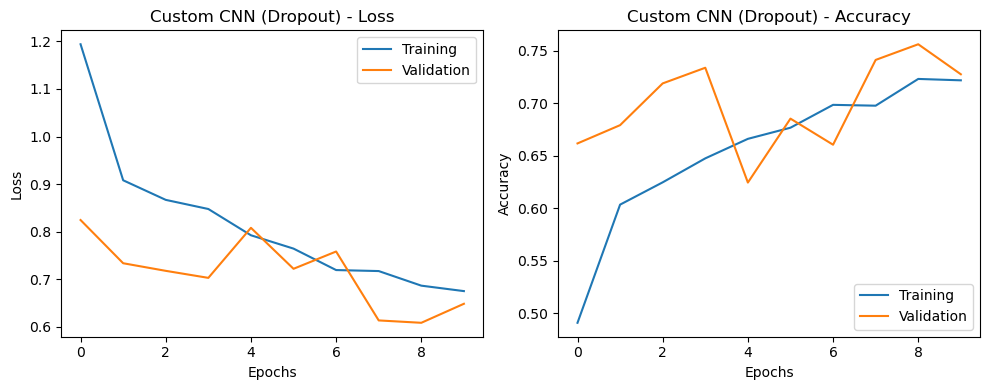

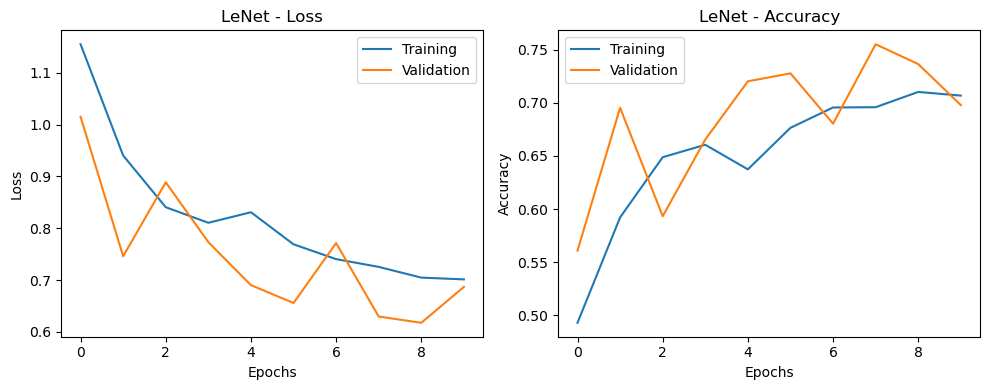

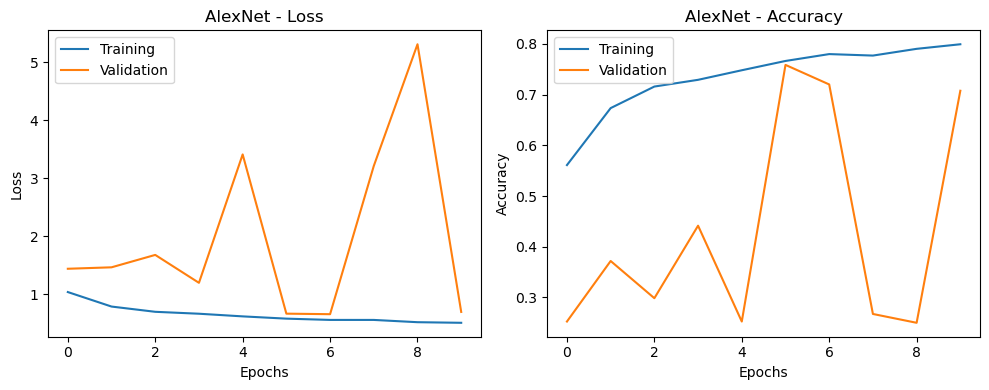

In [112]:
# Plot each accuracy/ loss curves
def plot_training_curves(history, model_name):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(cnn_history, "Custom CNN (Dropout)")
plot_training_curves(lenet_history, "LeNet")
plot_training_curves(alexnet_history, "AlexNet")

In [ ]:
# Hyperparameter summary
# CNN with multiple convolutional layers and maxpooling and dropout for regulation: 10 epochs, Adam (learning rate= 0.001), batch size: 32
# AlexNet: 10 epochs, Adam (learning rate=0.0001), batch size: 32
# LeNet: 10 epochs, Adam (learning rate=0.0001), batch size: 32

In [ ]:
# 6. Augmentation: The model we chose to retrain is the baseline CNN model

In [114]:
# Define augmentated data generator

augmented_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

augmented_train_generator = augmented_train_datagen.flow_from_directory(
    train_path,
    target_size=(192, 192),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(192, 192),
    batch_size=32,
    class_mode='categorical'
)

Found 3764 images belonging to 4 classes.
Found 804 images belonging to 4 classes.


In [116]:
# Rebuild and train the baseline CNN model

augmented_cnn = Sequential([
    Input(shape=(192, 192, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

augmented_cnn.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

augmented_history = augmented_cnn.fit(
    augmented_train_generator,
    epochs=10,
    validation_data=val_generator
)

C:\Users\bysun\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 79s 633ms/step - accuracy: 0.3864 - loss: 2.1445 - val_accuracy: 0.5672 - val_loss: 0.9594
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 72s 608ms/step - accuracy: 0.5284 - loss: 1.0567 - val_accuracy: 0.6704 - val_loss: 0.7994
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 70s 590ms/step - accuracy: 0.6141 - loss: 0.9049 - val_accuracy: 0.6716 - val_loss: 0.7704
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 69s 585ms/step - accuracy: 0.6424 - loss: 0.8310 - val_accuracy: 0.6555 - val_loss: 0.8407
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 78s 662ms/step - accuracy: 0.6723 - loss: 0.8000 - val_accuracy: 0.6940 - val_loss: 0.7262
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 76s 640ms/step - accuracy: 0.6663 - loss: 0.7925 - val_accuracy: 0.7226 - val_loss: 0.6601
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 72s 607ms/step - accuracy: 0.6832 - loss: 0.7630 - val_accuracy: 0.7189 - val_loss: 0.7390
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 71s 601ms/step - accuracy: 0.6950 - loss: 0

In [118]:
# Evaluate and compare the performance
aug_loss, aug_acc = augmented_cnn.evaluate(test_generator)
print(f"Augmented CNN → Test Accuracy: {aug_acc:.4f}, Test Loss: {aug_loss:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.7318 - loss: 0.6595
Augmented CNN → Test Accuracy: 0.7562, Test Loss: 0.6108


In [ ]:
# Description:
# We retrained the baseline CNN using techniques including random horizontal flipping, brightness adjustment, zooming and rotation. 
# These augmemtations simulate real-world variability in chest x-ray imaging and help the model to generalize better.
# Compared to the original baseline CNN model, the model with augmentation showed that there is a higher test accuracy.

In [ ]:
# 7. Interpretability & Insights
# Among all of the models we trained, the baseline CNN actually achieved highest test accuracy of 0.8247.
# We can see that there is a generally steady increase in the test accuracy.
# Radiologists who perform analysis of chest x-rays would benefit from this. Recourses-limited areas where the clinics lack radiology expertise would also benefit from this.
# In the real-world scenarios, it would also be useful as training assistance for junior radiologists using AI-based decision support.